In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import data
from hyperparameters import SimArgs
from parameters import weight_generation, weight_generation_r1
from jax.example_libraries import optimizers
# check gpu with jax
print(jax.devices())
first_exec = True

[CpuDevice(id=0)]


I0000 00:00:1714747893.582877       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
import sys
print(sys.executable)  # Shows the path to the Python interpreter
print(sys.version)     # Shows the Python version

/Users/tristantorchet/Desktop/SNN/SNN_venv/bin/python3
3.10.2 (main, Sep 28 2023, 20:12:42) [Clang 14.0.3 (clang-1403.0.22.14.1)]


In [3]:
n_in = 700
n_h = 256 
seed = 42
tau_mem = 20e-3
transition_steps = 1000
transition_begin = 1000
noise_injection_std = 0.1
nb_epochs = 50
args = SimArgs(n_in, n_h, seed, tau_mem, transition_steps, transition_begin, noise_injection_std, nb_epochs)
args.lr = 0.001

In [4]:
train_loader, val_loader, test_loader = data.get_data_loaders(args)
in_spikes_test_batch0, gt_labels_test_batch0 = next(iter(test_loader))
print(f'{in_spikes_test_batch0.shape=}, {gt_labels_test_batch0.shape=}')
print(f'We will vmap on the first dimension, so each thread will process one sample of size {in_spikes_test_batch0.shape[1:]}')
print(f'We will scan on the first dimension of the sample, so at every timestep we will process a 1-D array of size {in_spikes_test_batch0.shape[2]}')

datasets:
 - available at: /Users/tristantorchet/Desktop/SNN/audiospikes_700/shd_train.h5
 - available at: /Users/tristantorchet/Desktop/SNN/audiospikes_700/shd_test.h5
in_spikes_test_batch0.shape=(64, 150, 700), gt_labels_test_batch0.shape=(64,)
We will vmap on the first dimension, so each thread will process one sample of size (150, 700)
We will scan on the first dimension of the sample, so at every timestep we will process a 1-D array of size 700


In [18]:
@jax.custom_jvp
def gr_than(x, thr):
    """ Thresholding function for spiking neurons. """
    return (x > thr).astype(jnp.float32)


@gr_than.defjvp
def gr_jvp(primals, tangents):
    """ Surrogate gradient function for thresholding. """
    x, thr = primals
    x_dot, y_dot = tangents
    primal_out = gr_than(x, thr)
    tangent_out = x_dot / (10 * jnp.absolute(x - thr) + 1)**2
    return primal_out, tangent_out


def lif_recurrent(state, input_spikes):
    ''' Vectorized Recurrent Leaky Integrate and Fire (LIF) neuron model
    '''
    tau_mem, v_th, timestep = state[1] 
    ((Win, Wrec, Wout), (i_h, v_h, z_h), (i, v, z)) = state[0]
    i_h = jnp.dot(Win, input_spikes) + jnp.dot(Wrec, z_h)
    # comment the line above and uncomment the line below to add trainable bias
    # ((Win, Wrec, Wout, Wb), (i_h, v_h, z_h), (i, v, z)) = state[0]
    # i_h = jnp.dot(Win, input_spikes) + jnp.dot(Wrec, z_h) + Wb
    v_h = (1 - timestep / tau_mem) * v_h + i_h - z_h * v_th
    v_h = jnp.maximum(0, v_h)
    z_h = gr_than(v_h, v_th)
    i = jnp.dot(Wout, z_h)
    v = (1 - timestep / tau_mem) * v + i - z * v_th
    v = jnp.maximum(0, v)
    z = gr_than(v, v_th)
    return (([Win, Wrec, Wout], (i_h, v_h, z_h), (i, v, z)), state[1]), (z_h, v, z)
    # return (([Win, Wrec, Wout, Wb], (i_h, v_h, z_h), (i, v, z)), state[1]), (z_h, v, z)
        

In [19]:
def prediction_r1(w, hp, in_spikes):
    i_h = jnp.zeros((w[0].shape[0],))
    v_h = jnp.zeros((w[0].shape[0],))
    z_h = jnp.zeros((w[0].shape[0],))
    i = jnp.zeros((w[2].shape[0],))
    v = jnp.zeros((w[2].shape[0],))
    z = jnp.zeros((w[2].shape[0],))
    state = ((w, (i_h, v_h, z_h), (i, v, z)), hp)
    _, (z_h, v, z) = jax.lax.scan(lif_recurrent, state, in_spikes)
    return z_h, v, z

    
prediction_jv_r1 = jax.jit(jax.vmap(prediction_r1, in_axes=(None, None, 0)), static_argnums=(1,))

def loss_fn(w, hp, in_spikes, gt_labels):
    _, v, _ = prediction_jv_r1(w, hp, in_spikes)
    out = jnp.max(v, axis=1)
    logit = jax.nn.softmax(out)
    loss = -jnp.mean(jnp.log(logit[jnp.arange(gt_labels.shape[0]), gt_labels]))
    
    pred = jnp.argmax(out, axis=1)
    acc = jnp.count_nonzero(pred == gt_labels) / gt_labels.shape[0]
    return loss, acc


def update(opt, hp, in_spikes, gt_labels, e):
    get_params, opt_state, opt_update = opt
    w = get_params(opt_state)
    (loss, acc), grads = jax.value_and_grad(loss_fn, has_aux=True)(w, hp, in_spikes, gt_labels)
    opt_state = opt_update(e, grads, opt_state)
    return (loss, acc), (get_params, opt_state, opt_update)
    
def run_epoch(opt, hp, loader, e):
    epoch_loss = jnp.zeros((len(loader)))
    epoch_acc = jnp.zeros((len(loader)))
    for id_batch, (in_spikes, gt_labels) in enumerate(loader):
        (loss, acc), opt = update(opt, hp, in_spikes, gt_labels, e)
        epoch_loss = epoch_loss.at[id_batch].set(loss)
        epoch_acc = epoch_acc.at[id_batch].set(acc)
    return (epoch_loss, epoch_acc), opt

def inference(w, hp, loader):
    inference_loss = np.zeros((len(loader)))
    inference_acc = np.zeros((len(loader)))
    full_label = []
    full_pred = []
    for id_batch, (in_spikes, gt_labels) in enumerate(loader): 
        _, v, _ = prediction_jv_r1(w, hp, in_spikes)
        out = jnp.max(v, axis=1)
        logit = jax.nn.softmax(out)
        inference_loss[id_batch] = -jnp.mean(jnp.log(logit[jnp.arange(gt_labels.shape[0]), gt_labels]))
        
        pred = jnp.argmax(out, axis=1)
        inference_acc[id_batch] = jnp.count_nonzero(pred == gt_labels) / gt_labels.shape[0]
        full_label.append(gt_labels)
        full_pred.append(pred)
    full_label = np.concatenate(full_label, axis=0)
    full_pred = np.concatenate(full_pred, axis=0)

    return inference_loss, inference_acc, (full_label, full_pred)

def train(w, hp, train_loader, val_loader, test_loader):
    
    opt_init, opt_update, get_params = optimizers.adam(step_size=args.lr)
    opt_state = opt_init(w)
    print(f'{"Epoch":<6}|{"Loss":<10}|{"Acc":<10}|{"Val Acc":<10}|{"Test Acc":<10}|{"Val Loss":<10}|{"Test Loss":<10}')
    print(f'{"-"*6}|{"-"*10}|{"-"*10}|{"-"*10}|{"-"*10}|{"-"*10}|{"-"*10}')
    best_val_acc = 0.05 # Random guess
    test_loss = jnp.nan
    patience = 20
    best_opt_state = None
    hist_train_loss = np.zeros((args.nb_epochs))
    hist_val_loss = np.zeros((args.nb_epochs))
    hist_test_loss = np.zeros((args.nb_epochs))
    opt = (get_params, opt_state, opt_update)
    for e in range(args.nb_epochs):
        (epoch_loss, epoch_acc), opt = run_epoch(opt, hp, train_loader, e)
        _, opt_state, _ = opt
        val_loss, val_acc, _ = inference(get_params(opt_state), hp, val_loader)
        if val_acc.mean() > best_val_acc:
            best_val_acc = val_acc.mean()
            best_opt_state = opt_state
            patience = 20
            test_loss, test_acc, _ = inference(get_params(opt_state), hp, test_loader)
            print(f'{e:<6}|{epoch_loss.mean():<10.4f}|{epoch_acc.mean():<10.4f}|{val_acc.mean():<10.4f}|{test_acc.mean():<10.4f}|{val_loss.mean():<10.4f}|{test_loss.mean():<10.4f}')
        else:
            patience -= 1
            if e % 10 == 0:
                print(f'{e:<6}|{epoch_loss.mean():<10.4f}|{epoch_acc.mean():<10.4f}|{val_acc.mean():<10.4f}|{"-":<10}|{val_loss.mean():<10.4f}|{"-":<10}')  
            if patience == 0:
                break
        hist_train_loss[e] = epoch_loss.mean()
        hist_val_loss[e] = val_loss.mean()
        hist_test_loss[e] = test_loss.mean()
    
    test_loss, test_acc, _ = inference(get_params(opt_state), hp, test_loader)
    print(f'{e:<6}|{"":<10}|{"":<10}|{"":<10}|{test_acc.mean():<10.4f}|{"":<10}|{test_loss.mean():<10.4f}') 
    
    return get_params, best_opt_state, (hist_train_loss, hist_val_loss, hist_test_loss)    

In [20]:
key = jax.random.PRNGKey(args.seed)
key, w = weight_generation_r1(key, args, visualize_plot=False)
win_original  = w[0]
wrec_original = w[1]
wout_original = w[2]
print(f'{win_original.shape=}, {wrec_original.shape=}, {wout_original.shape=}, {len(w)=}')
# key, subkey = jax.random.split(key)
# wb = jax.random.normal(subkey, (args.n_h,))
# w.append(wb)
# print(f'{win_original.shape=}, {wrec_original.shape=}, {wb.shape=}, {wout_original.shape=}, {len(w)=}')
hp = (args.tau_mem, args.v_thr, args.timestep)

win_original.shape=(256, 700), wrec_original.shape=(256, 256), wout_original.shape=(20, 256), len(w)=3


In [21]:
first_exec = True ; save_w = True
if first_exec:
    get_params, opt_state, hist = train(w, hp, train_loader, val_loader, test_loader)
    w = get_params(opt_state)
    print(f'{len(w)=}')
    first_exec = False
    if save_w: 
        if len(w) == 3: 
            jnp.save('trained_w/cramer20/r1_no_bias/win.npy', w[0])
            jnp.save('trained_w/cramer20/r1_no_bias/wrec.npy', w[1])
            jnp.save('trained_w/cramer20/r1_no_bias/wout.npy', w[2])
        elif len(w) == 4: 
            jnp.save('trained_w/cramer20/r1_bias/win.npy', w[0])
            jnp.save('trained_w/cramer20/r1_bias/wrec.npy', w[1])
            jnp.save('trained_w/cramer20/r1_bias/wout.npy', w[2])
            jnp.save('trained_w/cramer20/r1_bias/wb.npy', w[3])
        else: 
            print('ERROR')
else:
    if len(w) == 3: 
        win  = jnp.load('trained_w/cramer20/cramer20/r1_bias/win.npy')
        wrec = jnp.load('trained_w/cramer20/cramer20/r1_bias/wrec.npy')
        wout = jnp.load('trained_w/cramer20/cramer20/r1_bias/wout.npy')
        w = [win, wrec, wout]
    elif len(w) == 4: 
        win  = jnp.load('trained_w/cramer20/cramer20/r1_bias/win.npy')
        wrec = jnp.load('trained_w/cramer20/cramer20/r1_bias/wrec.npy')
        wout = jnp.load('trained_w/cramer20/cramer20/r1_bias/wout.npy')
        wb   = jnp.load('trained_w/cramer20/cramer20/r1_bias/wb.npy')
        w = [win, wrec, wout, wb]

Epoch |Loss      |Acc       |Val Acc   |Test Acc  |Val Loss  |Test Loss 
------|----------|----------|----------|----------|----------|----------
0     |2.5984    |0.1683    |0.2562    |0.3040    |2.2371    |2.1488    
1     |2.0309    |0.3243    |0.3588    |0.3728    |1.9117    |1.8604    
2     |1.8009    |0.3962    |0.4194    |0.4241    |1.7398    |1.7380    
3     |1.6653    |0.4389    |0.4412    |0.4629    |1.6557    |1.6344    
4     |1.5715    |0.4793    |0.4544    |0.4879    |1.5835    |1.5828    
5     |1.4890    |0.4983    |0.4925    |0.4915    |1.5145    |1.5269    
7     |1.3534    |0.5492    |0.5125    |0.4969    |1.3859    |1.4352    
8     |1.2933    |0.5817    |0.5519    |0.5321    |1.3508    |1.3715    
9     |1.2373    |0.5965    |0.5550    |0.5223    |1.2996    |1.3440    
10    |1.1847    |0.6202    |0.5750    |0.5424    |1.2669    |1.3275    
11    |1.1341    |0.6411    |0.6031    |0.5589    |1.2036    |1.3053    
12    |1.0892    |0.6593    |0.6144    |0.5665    |

In [23]:
test_loss, test_acc, (test_lbls, test_preds) = inference(w, hp, test_loader)
print(f'{test_lbls.shape=}')
print(f'{test_loss.mean()=:.4f}, {test_acc.mean()=:.4f}')
if len(w) ==3: 
    test_loss_original, test_acc_original, (test_lbls_original, test_preds_original) = inference([win_original, wrec_original, wout_original], hp, test_loader)
elif len(w) == 4: 
    test_loss_original, test_acc_original, (test_lbls_original, test_preds_original) = inference([win_original, wrec_original, wout_original, wb], hp, test_loader)
else: 
    print("ERROR")

print(f'{test_loss_original.mean()=:.4f}, {test_acc_original.mean()=:.4f}')

test_lbls.shape=(2240,)
test_loss.mean()=1.3336, test_acc.mean()=0.5911
test_loss_original.mean()=3.2185, test_acc_original.mean()=0.0469


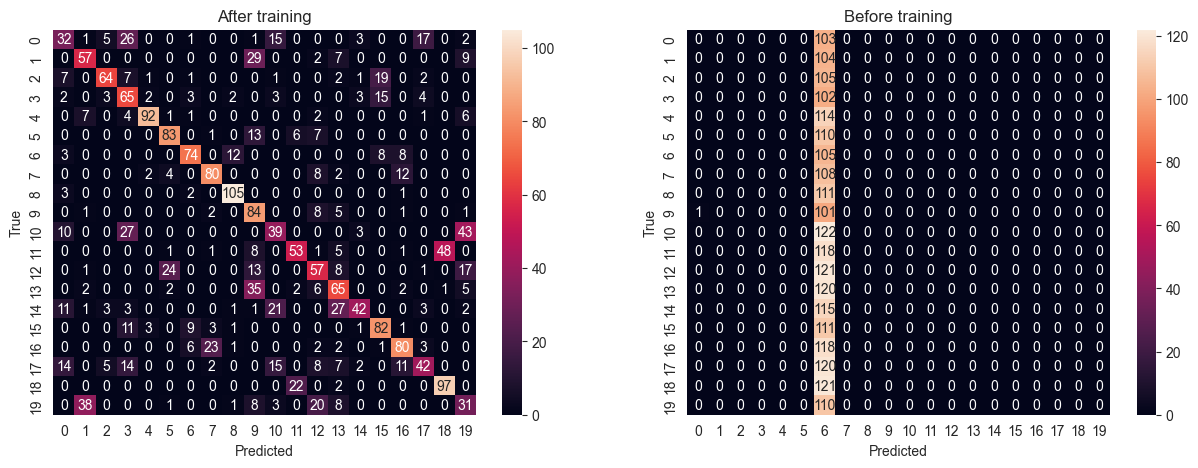

In [24]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(test_lbls, test_preds)
cm_original = confusion_matrix(test_lbls_original, test_preds_original)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
#cm_mask = np.where(cm > 5, 0, 1)
sns.heatmap(cm, annot=True, ax=ax[0], fmt='g')#, mask=cm_mask)
sns.heatmap(cm_original, annot=True, ax=ax[1], fmt='g')
ax[0].set_title('After training')
ax[1].set_title('Before training')
# set x and y labels
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')
# save 
if len(w) == 3: 
    plt.savefig('images/cramer20/r1_no_bias_cm_10e.png', transparent=False, format='png')
elif len(w)==4:
    plt.savefig('images/cramer20/r1_bias_cm_10e.png', transparent=False, format='png')
plt.show()

In [25]:
# use sklearn for the classification report
from sklearn.metrics import classification_report
print(classification_report(test_lbls, test_preds))
# print report sorted by f1-score
report = classification_report(test_lbls, test_preds, output_dict=True)
# report as pandas dataframe
import pandas as pd
report = pd.DataFrame(report).T
#sort report by f1
print(report[:20].sort_values('f1-score', ascending=False))

              precision    recall  f1-score   support

           0       0.39      0.31      0.35       103
           1       0.53      0.55      0.54       104
           2       0.80      0.61      0.69       105
           3       0.41      0.64      0.50       102
           4       0.92      0.81      0.86       114
           5       0.72      0.75      0.73       110
           6       0.76      0.70      0.73       105
           7       0.71      0.74      0.73       108
           8       0.85      0.95      0.90       111
           9       0.44      0.82      0.57       102
          10       0.40      0.32      0.36       122
          11       0.64      0.45      0.53       118
          12       0.47      0.47      0.47       121
          13       0.46      0.54      0.50       120
          14       0.76      0.37      0.49       115
          15       0.66      0.74      0.69       111
          16       0.68      0.68      0.68       118
          17       0.58    

In [13]:
zh_original, v_original, z_original = prediction_jv_r1([win_original, wrec_original, wout_original, wb], hp, in_spikes_test_batch0)
zh, v, z = prediction_jv_r1(w, hp, in_spikes_test_batch0)

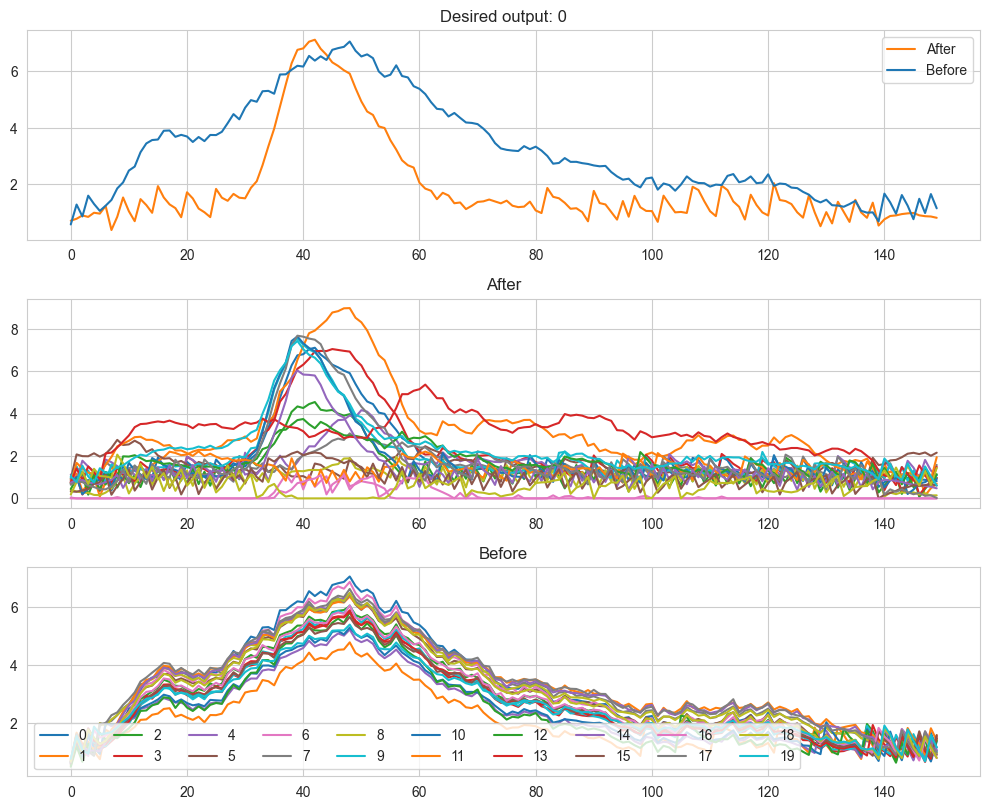

In [55]:
import matplotlib.pyplot as plt
id_sample = 6
v0_original = v_original[id_sample]
v0 = v[id_sample]
# plot the membrane potential of the 20 neurons with 150 timestep 
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

for i in range(20):
    if i == gt_labels_test_batch0[id_sample]:
        ax[0].plot(v0[:, i], label=f'After', color='C1')
        ax[0].plot(v0_original[:, i], label='Before', color='C0')
    ax[1].plot(v0[:, i], label=f'{i}')
    ax[2].plot(v0_original[:, i], label=f'{i}')
titles = [f'Desired output: {gt_labels_test_batch0[id_sample]}', 'After', 'Before']
for i in range(3):
    ax[i].set_title(f'{titles[i]}')
    if i!=1: ax[i].legend()
fig.tight_layout()
plt.legend(ncol=10, loc='lower left')
plt.show()
        

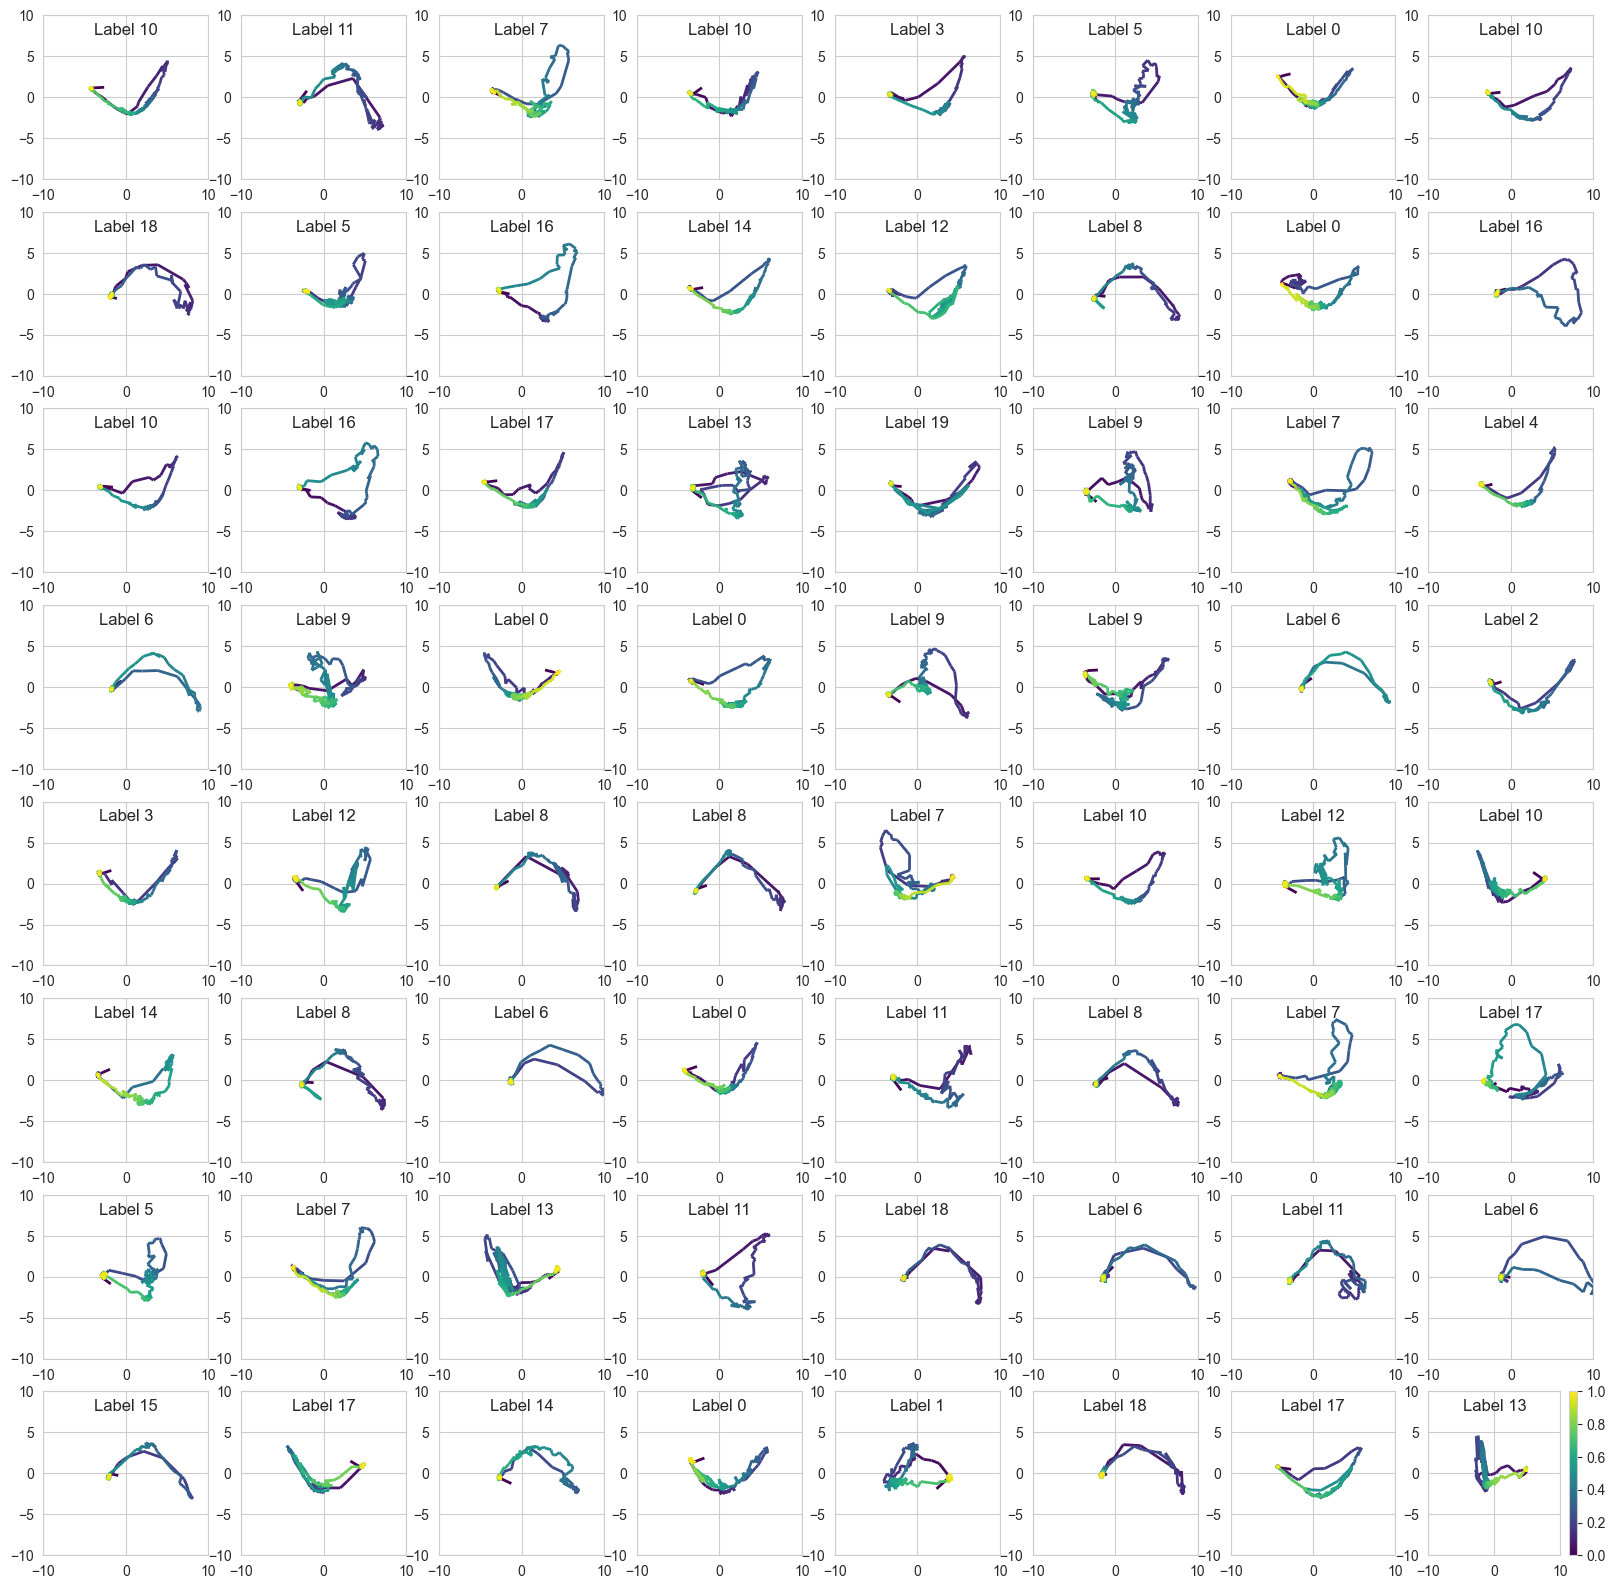

In [57]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

t = np.arange(150)

fig, axs = plt.subplots(8, 8, figsize=(20, 20))
for i in range(64):
    zh0 = zh[i]
    zh0_pca = pca.fit_transform(zh0)
    x    = zh0_pca[:, 0]
    y    = zh0_pca[:, 1]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cols = np.linspace(0,1,len(x))
    lc = LineCollection(segments, cmap='viridis')
    lc.set_array(cols)
    lc.set_linewidth(2)
    line = axs[i//8, i%8].add_collection(lc)
    # set x and y limits
    axs[i//8, i%8].set_xlim(-10, 10)
    axs[i//8, i%8].set_ylim(-10, 10)
    # add a title with the label
    axs[i//8, i%8].set_title(f'Label {gt_labels_test_batch0[i]}', y=1, pad=-14)

fig.colorbar(line ,ax=axs[i//8, i%8])

# make the line a gradient of color
# display colorbar
#plt.colorbar()
plt.show()

In [61]:
wrec = w[1]
# compute the rank of wrec
from scipy.linalg import svdvals
print(f'{np.linalg.matrix_rank(wrec)=}')
print(f'{np.linalg.matrix_rank(wrec_original)=}')


np.linalg.matrix_rank(wrec)=256
np.linalg.matrix_rank(wrec_original)=256
